# Project: Predicting Financial Account Ownership Using World Bank Indicators

Business Understanding

The goal of this project is to understand which country-level factors influence financial account ownership and whether a machine learning model can predict account ownership based on economic, demographic, and digital indicators.
The analysis uses selected indicators from the World Bank database for countries where data is available.

This project explores:

What the most influential factors of financial account ownership are.

How socioeconomic and digital variables relate to financial inclusion.

Whether a predictive model can estimate account ownership reliably.

What policy directions may help improve financial inclusion globally.

# Data Understanding

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time
from xgboost import XGBRegressor
import sha

In [2]:
# Load dataset 
df = pd.read_csv('WDI_Data.csv')

# Replace ".." with NaN for missing values handling
df.replace("..", np.nan, inplace=True)

# Identify the year columns dynamically
year_cols = [col for col in df.columns if "[YR" in col]

# Convert wide format to long format
df_long = df.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

# Clean Year column to be numeric removing "[YRxxxx]" text
df_long["Year"] = df_long["Year"].str.extract(r'(\d+)', expand=False).astype(int)

# Convert all numeric values to float
df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")

# Pivot to One row per country with year, with indicators (features) as columns
df_clean = df_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Series Name",
    values="Value"
).reset_index()

# Check the shape and first few rows
# print("ML Dataset Shape:", df_clean.shape)
# df_clean.head()

# Set target column 
target_col = "Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)"

# Filter rows where target is non-null
df_final = df_clean[df_clean[target_col].notna()].copy()

print(df_final.shape)
df_final.head()

(493, 18)


Series Name,Country Name,Country Code,Year,Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Adjusted net national income (current US$),Domestic credit to private sector (% of GDP),"Employment to population ratio, 15+, total (%) (national estimate)",GDP per capita (current US$),Individuals using the Internet (% of population),"Inflation, consumer prices (annual %)","Labor force participation rate, female (% of female population ages 15+) (national estimate)","Labor force participation rate, total (% of total population ages 15+) (national estimate)","Life expectancy at birth, total (years)","Literacy rate, adult total (% of people ages 15 and above)",Mobile cellular subscriptions (per 100 people),"School enrollment, secondary (% gross)",Secure Internet servers,Urban population (% of total population)
2,Afghanistan,AFG,2017,14.893312,1.775189e+10,3.841881,42.015,525.469771,13.5000,4.975952,21.171,47.305,62.406000,NaN,67.0508,55.536430,1577.0,25.250000
6,Afghanistan,AFG,2021,9.653822,1.362107e+10,NaN,46.906,356.496214,16.5143,5.133203,23.300,49.730,60.417000,37.270000,56.6945,NaN,1565.0,26.314000
12,Africa Eastern and Southern,AFE,2017,46.035518,8.308708e+11,66.525945,NaN,1520.212231,17.3000,6.399343,NaN,NaN,62.591275,70.879730,63.5000,43.254089,NaN,35.396289
16,Africa Eastern and Southern,AFE,2021,52.867354,8.663151e+11,51.162771,NaN,1522.393346,28.2000,7.240978,NaN,NaN,62.979999,72.715973,74.7000,45.150532,NaN,37.393633
19,Africa Eastern and Southern,AFE,2024,58.701075,NaN,NaN,NaN,1567.635839,35.0000,4.425471,NaN,NaN,NaN,73.695129,NaN,45.606079,NaN,38.949114


In [3]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493 entries, 2 to 2649
Data columns (total 18 columns):
 #   Column                                                                                                           Non-Null Count  Dtype  
---  ------                                                                                                           --------------  -----  
 0   Country Name                                                                                                     493 non-null    object 
 1   Country Code                                                                                                     493 non-null    object 
 2   Year                                                                                                             493 non-null    int64  
 3   Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)  493 non-null    float64
 4   Adjusted net national income (current

In [4]:
df_final.describe()

Series Name,Year,Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Adjusted net national income (current US$),Domestic credit to private sector (% of GDP),"Employment to population ratio, 15+, total (%) (national estimate)",GDP per capita (current US$),Individuals using the Internet (% of population),"Inflation, consumer prices (annual %)","Labor force participation rate, female (% of female population ages 15+) (national estimate)","Labor force participation rate, total (% of total population ages 15+) (national estimate)","Life expectancy at birth, total (years)","Literacy rate, adult total (% of people ages 15 and above)",Mobile cellular subscriptions (per 100 people),"School enrollment, secondary (% gross)",Secure Internet servers,Urban population (% of total population)
count,493.000000,493.000000,2.960000e+02,420.000000,309.000000,484.000000,391.000000,470.000000,300.000000,303.000000,330.000000,161.000000,332.000000,326.000000,4.200000e+02,490.000000
mean,2020.661258,65.974128,2.443959e+12,61.653957,56.601150,15903.420891,63.348920,6.377645,50.804950,60.609975,71.800084,83.803278,110.488274,86.047697,1.178202e+06,61.023333
std,2.891827,24.781914,8.325173e+12,48.768337,9.611896,21329.277230,27.297465,16.760834,13.167602,8.508379,7.883995,15.540851,33.656230,26.128368,9.171489e+06,20.947146
min,2017.000000,5.831407,1.108628e+09,1.705071,24.429000,356.496214,4.000000,-12.296984,10.767000,26.487000,35.351000,35.610001,24.520400,15.807440,2.000000e+00,16.350000
25%,2017.000000,45.316633,2.157434e+10,26.383455,52.211000,2188.606539,39.950000,1.970529,45.882250,56.168000,66.529500,73.695129,92.461175,72.615591,1.051250e+03,44.702500
50%,2021.000000,68.590308,1.256900e+11,48.854629,57.603757,6447.814701,71.581700,3.315831,53.371500,61.154000,72.763244,89.769997,112.065000,91.040960,9.707000e+03,60.464500
75%,2024.000000,88.709022,6.791543e+11,81.605178,61.940000,19504.139239,87.291400,5.132754,58.223500,65.492500,77.231738,96.040001,128.997000,102.911400,2.325522e+05,79.035250
max,2024.000000,100.000000,7.689246e+13,259.183988,81.294000,110193.213797,100.000000,219.883929,80.476000,81.536000,85.532683,100.000000,319.852000,158.670288,1.334267e+08,100.000000


# Data Preparation

In [5]:
# COLUMN-WISE MISSING VALUE ANALYSIS

# Calculate missing percentage for each feature
missing_pct = df_final.isna().mean().sort_values(ascending=False) * 100

print("\nMissing Percentage by Feature:\n")
print(missing_pct)


Missing Percentage by Feature:

Series Name
Literacy rate, adult total (% of people ages 15 and above)                                                         67.342799
Adjusted net national income (current US$)                                                                         39.959432
Labor force participation rate, female (% of female population ages 15+) (national estimate)                       39.148073
Labor force participation rate, total (% of total population ages 15+) (national estimate)                         38.539554
Employment to population ratio, 15+, total (%) (national estimate)                                                 37.322515
School enrollment, secondary (% gross)                                                                             33.874239
Life expectancy at birth, total (years)                                                                            33.062880
Mobile cellular subscriptions (per 100 people)                                  

In [6]:
# YEAR-WISE MISSING VALUE ANALYSIS

year_missing = (
    df_final.groupby("Year")
            .apply(lambda x: x.isna().mean().mean() * 100)
            .reset_index()
)

year_missing.columns = ["Year", "Avg_Missing_Percentage"]

print("\nYear-wise Missingness:\n")
print(year_missing)


Year-wise Missingness:

   Year  Avg_Missing_Percentage
0  2017               11.408730
1  2021               11.377473
2  2022               26.041667
3  2024               39.229721


In [7]:
# List of features to drop
# Dropping literacy rate since it is 67% missing
# dropping year since not all yeard data is not available
drop_features = [
    "Literacy rate, adult total (% of people ages 15 and above)", 
    "Year"  
]

df_prepared = df_final.drop(columns=drop_features)

print("New shape after dropping sparse features + Year:", df_prepared.shape)
df_prepared.head()


New shape after dropping sparse features + Year: (493, 16)


Series Name,Country Name,Country Code,Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Adjusted net national income (current US$),Domestic credit to private sector (% of GDP),"Employment to population ratio, 15+, total (%) (national estimate)",GDP per capita (current US$),Individuals using the Internet (% of population),"Inflation, consumer prices (annual %)","Labor force participation rate, female (% of female population ages 15+) (national estimate)","Labor force participation rate, total (% of total population ages 15+) (national estimate)","Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),"School enrollment, secondary (% gross)",Secure Internet servers,Urban population (% of total population)
2,Afghanistan,AFG,14.893312,1.775189e+10,3.841881,42.015,525.469771,13.5000,4.975952,21.171,47.305,62.406000,67.0508,55.536430,1577.0,25.250000
6,Afghanistan,AFG,9.653822,1.362107e+10,NaN,46.906,356.496214,16.5143,5.133203,23.300,49.730,60.417000,56.6945,NaN,1565.0,26.314000
12,Africa Eastern and Southern,AFE,46.035518,8.308708e+11,66.525945,NaN,1520.212231,17.3000,6.399343,NaN,NaN,62.591275,63.5000,43.254089,NaN,35.396289
16,Africa Eastern and Southern,AFE,52.867354,8.663151e+11,51.162771,NaN,1522.393346,28.2000,7.240978,NaN,NaN,62.979999,74.7000,45.150532,NaN,37.393633
19,Africa Eastern and Southern,AFE,58.701075,NaN,NaN,NaN,1567.635839,35.0000,4.425471,NaN,NaN,NaN,NaN,45.606079,NaN,38.949114


In [8]:
# MEDIAN IMPUTATION

# Define IDs and target columns
TARGET_COL = ("Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)")
ID_COLS = ["Country Name", "Country Code"]

# Identify feature columns
feature_cols = [c for c in df_prepared.columns if c not in ID_COLS + [TARGET_COL]]

print("Feature columns to impute:", feature_cols)

# Set up the median imputer
imputer = SimpleImputer(strategy="median")

# Fit and transform only the feature columns
X_imputed = imputer.fit_transform(df_prepared[feature_cols])

# Convert back to DataFrame keeping the same index and column names
df_features_imputed = pd.DataFrame(
    X_imputed,
    columns=feature_cols,
    index=df_prepared.index
)

# Reconstruct the final fully-imputed dataframe (df_model)
df_model = pd.concat(
    [
        df_prepared[ID_COLS].reset_index(drop=True),     # Country Name, Country Code
        df_prepared[[TARGET_COL]].reset_index(drop=True),# Target
        df_features_imputed.reset_index(drop=True)        # Imputed numeric features
    ],
    axis=1
)

# Sanity check
print("\nImputation complete.")
print("df_model shape:", df_model.shape)
print("Remaining missing values:", df_model.isna().sum().sum())

df_model.head()

Feature columns to impute: ['Adjusted net national income (current US$)', 'Domestic credit to private sector (% of GDP)', 'Employment to population ratio, 15+, total (%) (national estimate)', 'GDP per capita (current US$)', 'Individuals using the Internet (% of population)', 'Inflation, consumer prices (annual %)', 'Labor force participation rate, female (% of female population ages 15+) (national estimate)', 'Labor force participation rate, total (% of total population ages 15+) (national estimate)', 'Life expectancy at birth, total (years)', 'Mobile cellular subscriptions (per 100 people)', 'School enrollment, secondary (% gross)', 'Secure Internet servers', 'Urban population (% of total population)']

Imputation complete.
df_model shape: (493, 16)
Remaining missing values: 0


,Country Name,Country Code,Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Adjusted net national income (current US$),Domestic credit to private sector (% of GDP),"Employment to population ratio, 15+, total (%) (national estimate)",GDP per capita (current US$),Individuals using the Internet (% of population),"Inflation, consumer prices (annual %)","Labor force participation rate, female (% of female population ages 15+) (national estimate)","Labor force participation rate, total (% of total population ages 15+) (national estimate)","Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),"School enrollment, secondary (% gross)",Secure Internet servers,Urban population (% of total population)
0,Afghanistan,AFG,14.893312,1.775189e+10,3.841881,42.015000,525.469771,13.5000,4.975952,21.1710,47.305,62.406000,67.0508,55.536430,1577.0,25.250000
1,Afghanistan,AFG,9.653822,1.362107e+10,48.854629,46.906000,356.496214,16.5143,5.133203,23.3000,49.730,60.417000,56.6945,91.040960,1565.0,26.314000
2,Africa Eastern and Southern,AFE,46.035518,8.308708e+11,66.525945,57.603757,1520.212231,17.3000,6.399343,53.3715,61.154,62.591275,63.5000,43.254089,9707.0,35.396289
3,Africa Eastern and Southern,AFE,52.867354,8.663151e+11,51.162771,57.603757,1522.393346,28.2000,7.240978,53.3715,61.154,62.979999,74.7000,45.150532,9707.0,37.393633
4,Africa Eastern and Southern,AFE,58.701075,1.256900e+11,48.854629,57.603757,1567.635839,35.0000,4.425471,53.3715,61.154,72.763244,112.0650,45.606079,9707.0,38.949114


# Exploratory Data Analysis (EDA)

Shape of df_model: (493, 16)

Data Types:
 Country Name                                                                                                        object
Country Code                                                                                                        object
Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)    float64
Adjusted net national income (current US$)                                                                         float64
Domestic credit to private sector (% of GDP)                                                                       float64
Employment to population ratio, 15+, total (%) (national estimate)                                                 float64
GDP per capita (current US$)                                                                                       float64
Individuals using the Internet (% of population)                                                

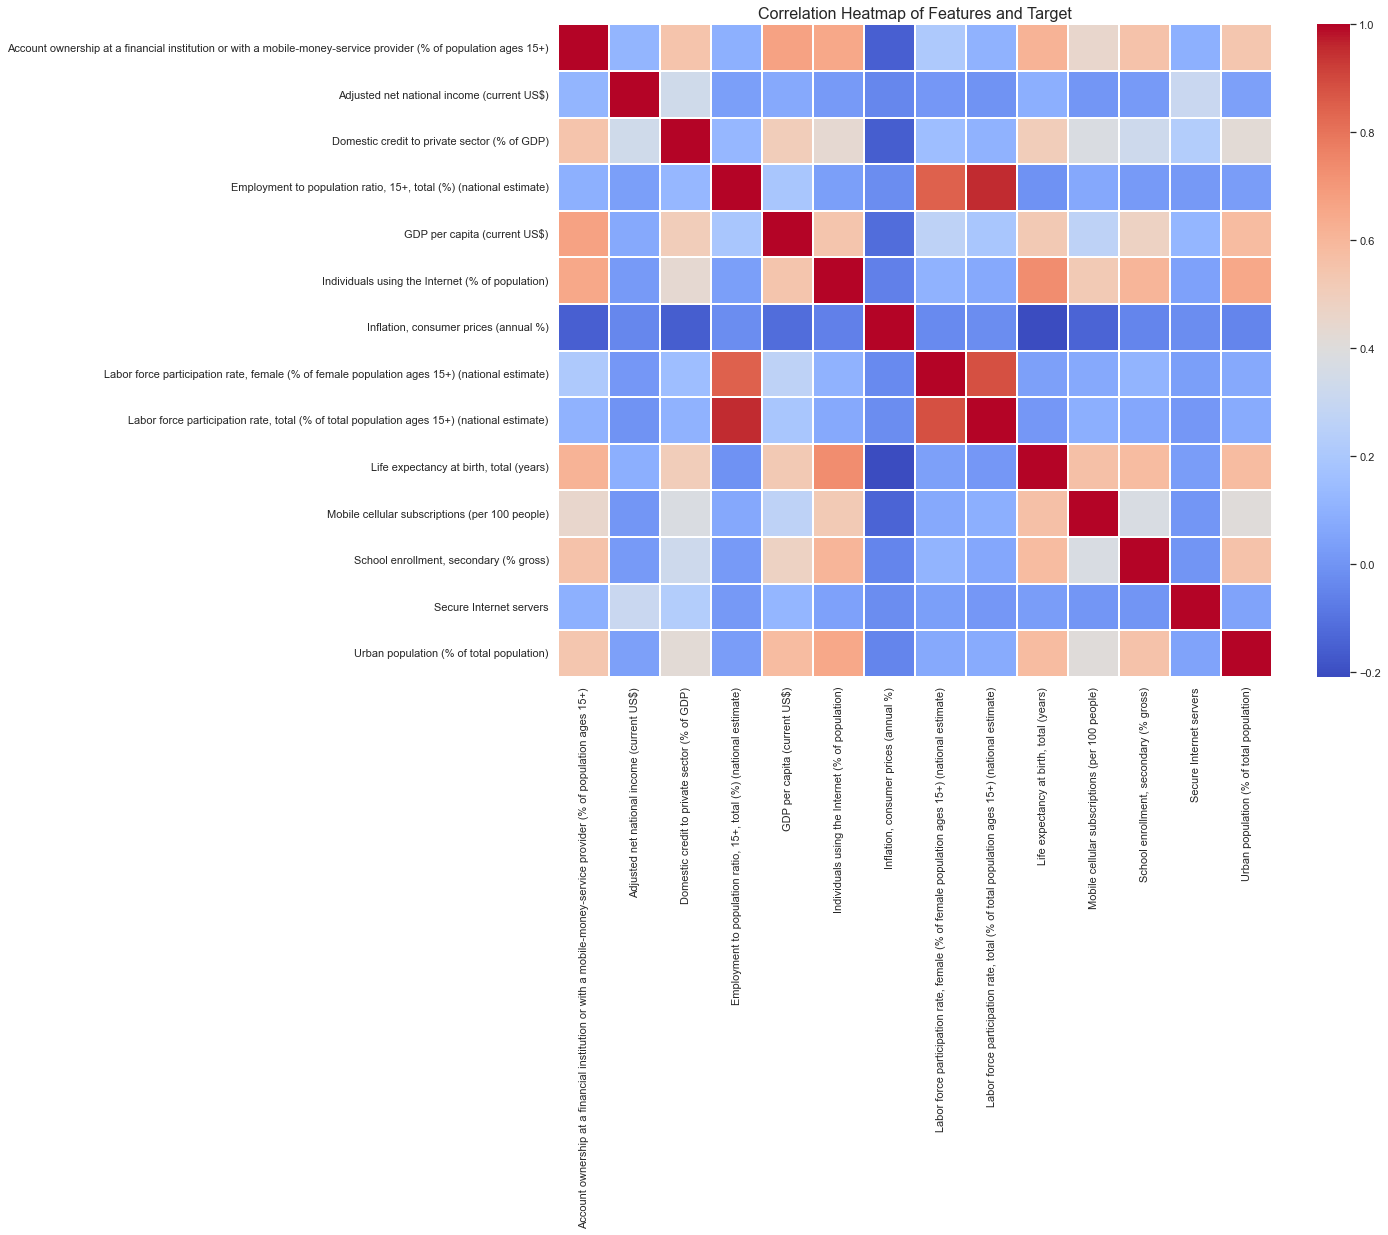

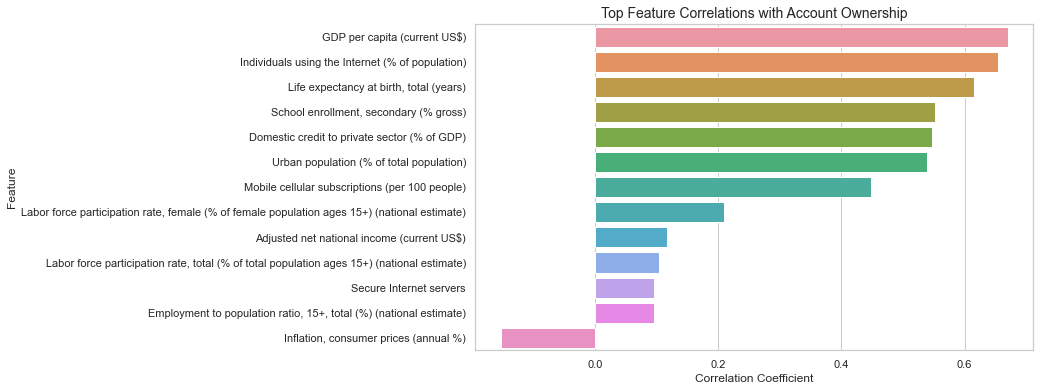


Top correlations with target:
 GDP per capita (current US$)                                                                    0.670657
Individuals using the Internet (% of population)                                                0.653655
Life expectancy at birth, total (years)                                                         0.615882
School enrollment, secondary (% gross)                                                          0.552166
Domestic credit to private sector (% of GDP)                                                    0.547242
Urban population (% of total population)                                                        0.539052
Mobile cellular subscriptions (per 100 people)                                                  0.447965
Labor force participation rate, female (% of female population ages 15+) (national estimate)    0.210110
Adjusted net national income (current US$)                                                      0.116530
Labor force participati

In [9]:
# EXPLORATORY DATA ANALYSIS

sns.set(style="whitegrid")

#  Basic info and summary stats


print("Shape of df_model:", df_model.shape)
print("\nData Types:\n", df_model.dtypes)


# Correlation Matrix (full heatmap)

plt.figure(figsize=(16, 12))
corr = df_model.drop(columns=["Country Name", "Country Code"]).corr()

sns.heatmap(
    corr, 
    cmap='coolwarm', 
    annot=False, 
    linewidths=0.3,
    fmt=".2f"
)
plt.title("Correlation Heatmap of Features and Target", fontsize=16)
plt.show()


# Top 10 correlations with the target (bar chart)


TARGET_COL = ("Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)")

target_corr = corr[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title("Top Feature Correlations with Account Ownership", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

print("\nTop correlations with target:\n", target_corr)

GDP per capita and internet usage show high positive correlation with account ownership.

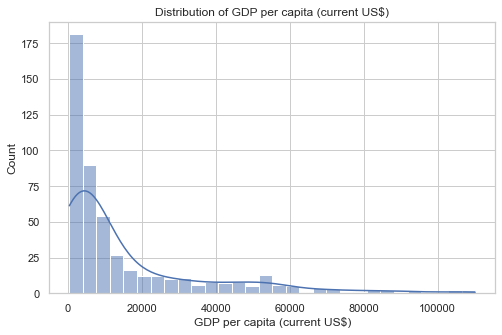

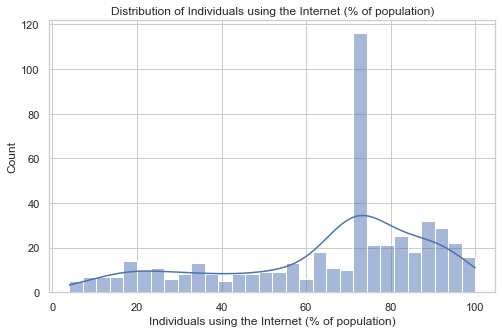

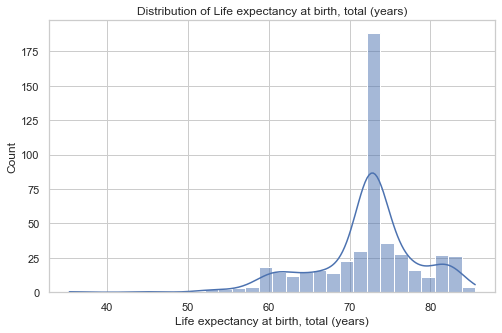

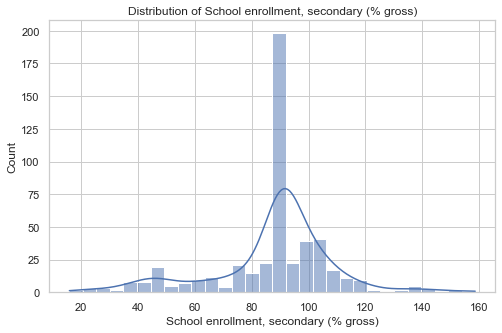

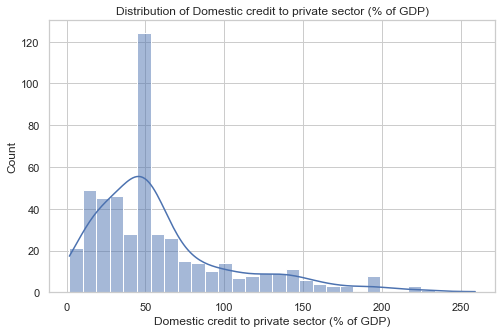

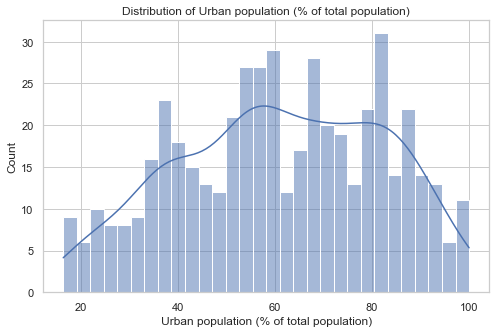

In [11]:
# Distribution plots of major numeric features


# Top 6 most important features from correlation analysis
important_features = [
    "GDP per capita (current US$)",
    "Individuals using the Internet (% of population)",
    "Life expectancy at birth, total (years)",
    "School enrollment, secondary (% gross)",
    "Domestic credit to private sector (% of GDP)",
    "Urban population (% of total population)"
]

for col in important_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_model[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.show()

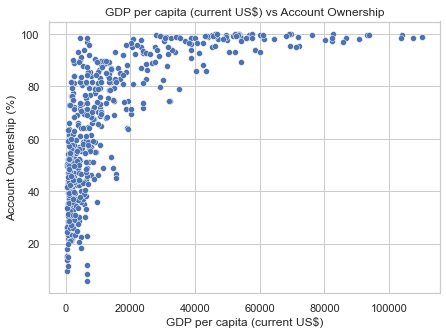

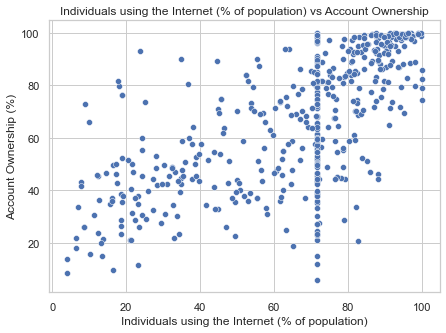

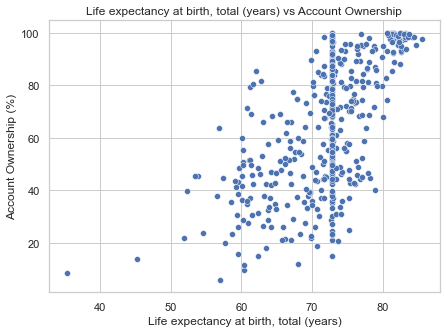

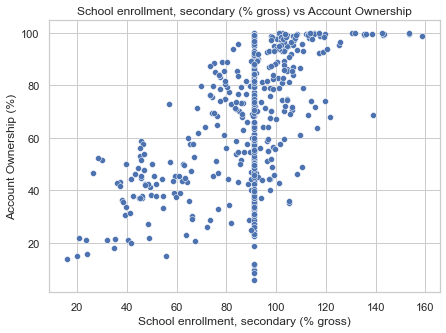

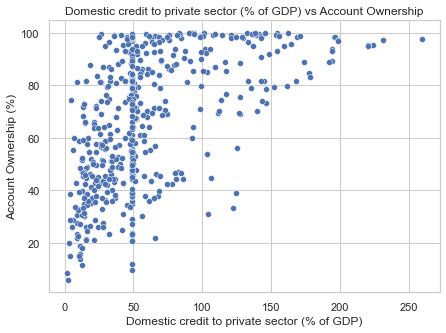

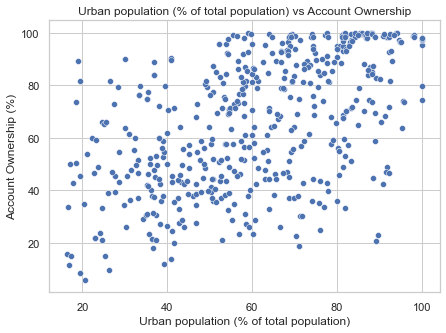

In [12]:
# Scatter plots of key features vs target


for col in important_features:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=df_model[col], y=df_model[TARGET_COL])
    plt.title(f"{col} vs Account Ownership")
    plt.xlabel(col)
    plt.ylabel("Account Ownership (%)")
    plt.show()

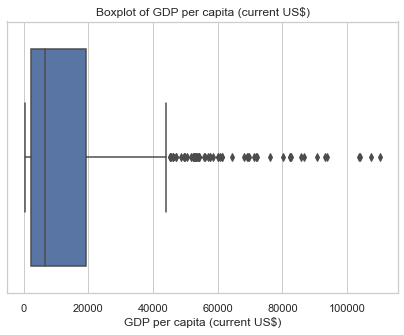

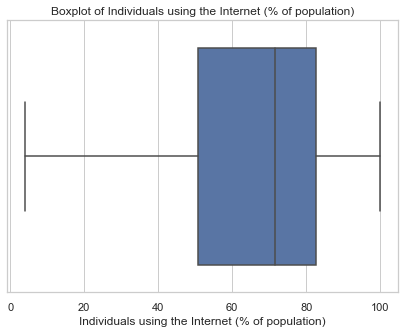

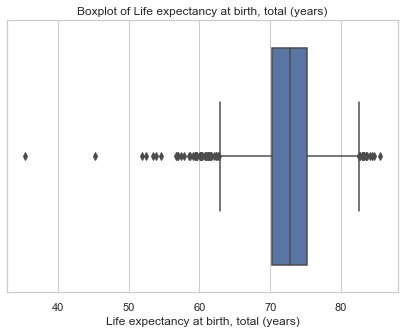

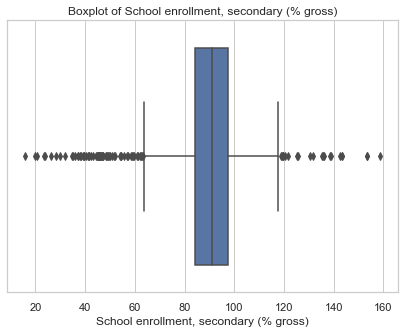

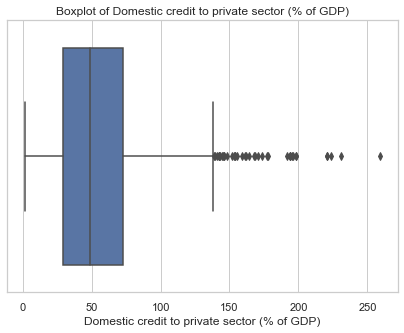

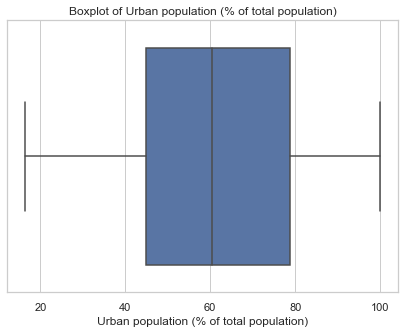

In [13]:
# Boxplots to detect outliers


for col in important_features:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=df_model[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# Feature Engineering

In [14]:
# FEATURE ENGINEERING


# Strong raw features identified via EDA
strong_raw_features = [
    "GDP per capita (current US$)",
    "Individuals using the Internet (% of population)",
    "Life expectancy at birth, total (years)",
    "School enrollment, secondary (% gross)",
    "Domestic credit to private sector (% of GDP)",
    "Urban population (% of total population)",
    "Mobile cellular subscriptions (per 100 people)"
]

# Log transforms for skewed features
df_model["log_gdp_per_capita"] = np.log1p(df_model["GDP per capita (current US$)"])
df_model["log_domestic_credit"] = np.log1p(df_model["Domestic credit to private sector (% of GDP)"])

# Interaction feature (optional but meaningful)
df_model["internet_x_urban"] = (
    (df_model["Individuals using the Internet (% of population)"] / 100) *
    (df_model["Urban population (% of total population)"] / 100)
)

# Final feature list
engineered_features = ["log_gdp_per_capita", "log_domestic_credit", "internet_x_urban"]
final_feature_list = strong_raw_features + engineered_features

print("Final features for modeling:", final_feature_list)
print("Total features:", len(final_feature_list))

# Build modeling dataframe
ID_COLS = ["Country Name", "Country Code"]
TARGET_COL = "Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)"

df_model_ready = df_model[ID_COLS + [TARGET_COL] + final_feature_list].copy()
df_model_ready.head()

Final features for modeling: ['GDP per capita (current US$)', 'Individuals using the Internet (% of population)', 'Life expectancy at birth, total (years)', 'School enrollment, secondary (% gross)', 'Domestic credit to private sector (% of GDP)', 'Urban population (% of total population)', 'Mobile cellular subscriptions (per 100 people)', 'log_gdp_per_capita', 'log_domestic_credit', 'internet_x_urban']
Total features: 10


,Country Name,Country Code,Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),GDP per capita (current US$),Individuals using the Internet (% of population),"Life expectancy at birth, total (years)","School enrollment, secondary (% gross)",Domestic credit to private sector (% of GDP),Urban population (% of total population),Mobile cellular subscriptions (per 100 people),log_gdp_per_capita,log_domestic_credit,internet_x_urban
0,Afghanistan,AFG,14.893312,525.469771,13.5000,62.406000,55.536430,3.841881,25.250000,67.0508,6.266194,1.577303,0.034087
1,Afghanistan,AFG,9.653822,356.496214,16.5143,60.417000,91.040960,48.854629,26.314000,56.6945,5.879125,3.909111,0.043456
2,Africa Eastern and Southern,AFE,46.035518,1520.212231,17.3000,62.591275,43.254089,66.525945,35.396289,63.5000,7.327263,4.212512,0.061236
3,Africa Eastern and Southern,AFE,52.867354,1522.393346,28.2000,62.979999,45.150532,51.162771,37.393633,74.7000,7.328696,3.954369,0.105450
4,Africa Eastern and Southern,AFE,58.701075,1567.635839,35.0000,72.763244,45.606079,48.854629,38.949114,112.0650,7.357962,3.909111,0.136322


In [18]:
# Removing original skewed features (keeping only log versions)
cols_to_remove = [
    "GDP per capita (current US$)",
    "Domestic credit to private sector (% of GDP)"
]

df_model_ready = df_model_ready.drop(columns=cols_to_remove)

print("Removed skewed original features. New shape:", df_model_ready.shape)
df_model_ready.head()


Removed skewed original features. New shape: (493, 11)


,Country Name,Country Code,Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Individuals using the Internet (% of population),"Life expectancy at birth, total (years)","School enrollment, secondary (% gross)",Urban population (% of total population),Mobile cellular subscriptions (per 100 people),log_gdp_per_capita,log_domestic_credit,internet_x_urban
0,Afghanistan,AFG,14.893312,13.5000,62.406000,55.536430,25.250000,67.0508,6.266194,1.577303,0.034087
1,Afghanistan,AFG,9.653822,16.5143,60.417000,91.040960,26.314000,56.6945,5.879125,3.909111,0.043456
2,Africa Eastern and Southern,AFE,46.035518,17.3000,62.591275,43.254089,35.396289,63.5000,7.327263,4.212512,0.061236
3,Africa Eastern and Southern,AFE,52.867354,28.2000,62.979999,45.150532,37.393633,74.7000,7.328696,3.954369,0.105450
4,Africa Eastern and Southern,AFE,58.701075,35.0000,72.763244,45.606079,38.949114,112.0650,7.357962,3.909111,0.136322


# Feature Scaling + Train/Test Split

In [19]:
# Train/Test Split + Scaling


# IDs and target (ensure these names match)
ID_COLS = ["Country Name", "Country Code"]
TARGET_COL = "Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)"

# Build X and y (drop IDs)
X = df_model_ready.drop(columns=ID_COLS + [TARGET_COL]).copy()
y = df_model_ready[TARGET_COL].copy()

# Sanity check
assert X.isna().sum().sum() == 0, "There are still missing values in X — impute first."
assert y.isna().sum() == 0, "Target contains missing values."

print("Feature matrix shape (X):", X.shape)
print("Target vector shape (y):", y.shape)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

print("\nAfter split:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

# StandardScaler for linear models (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames (preserve column names & index)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nScaled data shapes:")
print("X_train_scaled:", X_train_scaled.shape, "X_test_scaled:", X_test_scaled.shape)


# Quick distribution sanity check (print means)
print("\nFeature means before scaling (train):\n", X_train.mean().round(3).head())
print("\nFeature means after scaling (train):\n", X_train_scaled.mean().round(3).head())
print("\nFeature std after scaling (train):\n", X_train_scaled.std().round(3).head())

Feature matrix shape (X): (493, 8)
Target vector shape (y): (493,)

After split:
X_train: (394, 8) X_test: (99, 8)
y_train: (394,) y_test: (99,)

Scaled data shapes:
X_train_scaled: (394, 8) X_test_scaled: (99, 8)

Feature means before scaling (train):
 Individuals using the Internet (% of population)     65.897
Life expectancy at birth, total (years)              72.358
School enrollment, secondary (% gross)               87.532
Urban population (% of total population)             61.236
Mobile cellular subscriptions (per 100 people)      111.572
dtype: float64

Feature means after scaling (train):
 Individuals using the Internet (% of population)    0.0
Life expectancy at birth, total (years)             0.0
School enrollment, secondary (% gross)              0.0
Urban population (% of total population)           -0.0
Mobile cellular subscriptions (per 100 people)     -0.0
dtype: float64

Feature std after scaling (train):
 Individuals using the Internet (% of population)    1.001
Li

# Modelling and Evaluation

In [27]:
# MODELS 

RND = 42
CV = KFold(n_splits=5, shuffle=True, random_state=RND)

#def rmse(y, yhat): 
#    return np.sqrt(mean_squared_error(y, yhat))


# Define ALL models + expanded hyperparameter grids


model_grids = {

    "Linear": (
        LinearRegression(), 
        {}   # No params to tune
    ),

    "Ridge": (
        Ridge(random_state=RND),
        {
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100]
        }
    ),

    "Lasso": (
        Lasso(random_state=RND, max_iter=10000),
        {
            "alpha": [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
        }
    ),

    "RF": (
        RandomForestRegressor(random_state=RND, n_jobs=-1),
        {
            "n_estimators": [200, 400],
            "max_depth": [10, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    ),

    "GB": (
        GradientBoostingRegressor(random_state=RND),
        {
            "n_estimators": [200, 400],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [2, 3, 5],
            "subsample": [0.7, 0.9, 1.0]
        }
    ),

    "XGB": (
        XGBRegressor(
            random_state=RND,
            verbosity=0,
            n_jobs=-1,
            objective="reg:squarederror"
        ),
        {
            "n_estimators": [200, 400, 600],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.7, 1.0],
            "reg_lambda": [1, 2]
        }
    )
}


# Run GridSearchCV for ALL models


best_models = {}

for name, (estimator, params) in model_grids.items():

    print(f"\n GridSearchCV  {name}")
    
    # choose scaled/unscaled features
    X_used = X_train_scaled if name in ["Linear", "Ridge", "Lasso"] else X_train
    
    gs = GridSearchCV(
        estimator,
        params,
        scoring="r2",
        cv=CV,
        n_jobs=-1,
        verbose=1
    )
    
    t0 = time.time()
    gs.fit(X_used, y_train)
    t1 = time.time()
    
    print(f"  Best R2 = {gs.best_score_:.4f}")
    print(f"  Best Params = {gs.best_params_}")
    print(f"  Time Taken = {t1 - t0:.1f} sec")
    
    best_models[name] = gs.best_estimator_



# Evaluate on Test Set



print(" Test Set Results")


results = {}

for name, model in best_models.items():

    X_test_used = X_test_scaled if name in ["Linear", "Ridge", "Lasso"] else X_test
    y_pred = model.predict(X_test_used)

    results[name] = {
        "r2": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred),
        "rmse": rmse(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T
display(results_df.sort_values("r2", ascending=False))


 GridSearchCV  Linear
Fitting 5 folds for each of 1 candidates, totalling 5 fits
  Best R2 = 0.6489
  Best Params = {}
  Time Taken = 1.8 sec

 GridSearchCV  Ridge
Fitting 5 folds for each of 8 candidates, totalling 40 fits
  Best R2 = 0.6497
  Best Params = {'alpha': 1}
  Time Taken = 1.0 sec

 GridSearchCV  Lasso
Fitting 5 folds for each of 6 candidates, totalling 30 fits
  Best R2 = 0.6506
  Best Params = {'alpha': 0.1}
  Time Taken = 0.1 sec

 GridSearchCV  RF
Fitting 5 folds for each of 16 candidates, totalling 80 fits
  Best R2 = 0.7147
  Best Params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
  Time Taken = 11.0 sec

 GridSearchCV  GB
Fitting 5 folds for each of 54 candidates, totalling 270 fits
  Best R2 = 0.7151
  Best Params = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.7}
  Time Taken = 22.2 sec

 GridSearchCV  XGB
Fitting 5 folds for each of 96 candidates, totalling 480 fits
  Best R2 = 0.7158
  

,r2,mae,rmse
RF,0.726622,9.049257,13.210992
GB,0.717885,9.138618,13.420446
XGB,0.701090,9.312523,13.814135
Lasso,0.697441,10.005976,13.898194
Ridge,0.696648,10.098706,13.916394
Linear,0.696202,10.129661,13.926620


# Model Interpretation with SHAP

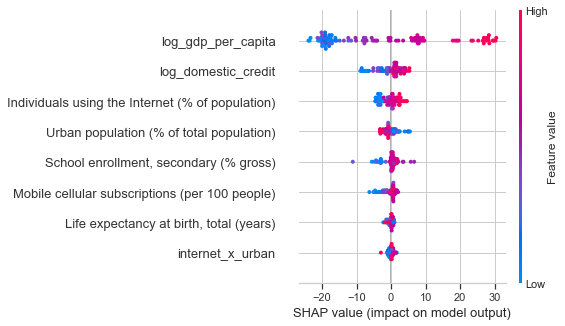

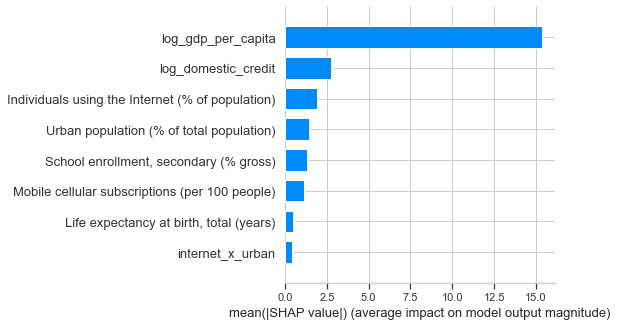

In [28]:
# SHAP INTERPRETATION FOR BEST MODEL (Random Forest)


best_model = best_models["RF"]     
X_test_shap = X_test                # raw features for tree models

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_shap)


# GLOBAL IMPORTANCE — SHAP SUMMARY PLOT

shap.summary_plot(shap_values, 
                  X_test_shap, 
                  plot_type="dot", 
                  show=True)


# GLOBAL IMPORTANCE — MEAN SHAP BAR PLOT

shap.summary_plot(shap_values, 
                  X_test_shap, 
                  plot_type="bar", 
                  show=True)

SHAP indicates log GDP per capita and log domestic credit are the most influential features; high values of these push predicted account ownership up.

# Business Answers & Insights

What factors are most strongly associated with higher financial account ownership among countries?

Based on the exploratory analysis and the model results, the two variables most strongly associated with higher account ownership are GDP per capita and domestic credit to the private sector. Both show a clear positive relationship with account ownership. Countries with higher income levels and more developed credit markets tend to have much higher financial inclusion. Internet usage, school enrollment, and urban population also show a meaningful positive association, suggesting that higher digital access, education levels, and urbanization help drive financial account ownership.


Does digital access (internet usage and mobile subscriptions) play an important role in predicting account ownership?

The scatter plots, correlations, and the models all show that digital access plays an important role. Internet usage has one of the highest correlations with account ownership, and it remains an important predictor in the tree-based models and in the SHAP values. While mobile subscriptions also help, they do not appear to be as strong as internet usage. Overall, the results suggest that improving access to digital connectivity can support financial inclusion.


Can we build a model that reliably estimates account ownership for a country based on its economic and digital indicators?

Using several regression models (Random Forest, Gradient Boosting, Ridge, Lasso, etc.), the Random Forest model performed the best, achieving an R² of about 0.72 on the test set. This means the model can explain roughly 72% of the variation in account ownership between countries. The most influential predictors in the model were log-transformed GDP per capita, log domestic credit, internet usage, school enrollment, and urban population. This shows that a predictive model can indeed be used to estimate financial inclusion levels using publicly available indicators.


Which areas should policymakers focus on to improve overall financial account ownership?

Based on the analysis, financial inclusion programs should prioritize strengthening the economic environment (higher income opportunities, access to formal credit), increasing digital connectivity (especially affordable internet), and improving education levels. Urbanization is also associated with higher inclusion, although it is not a policy lever in itself. In short, improving both economic development and digital infrastructure appears to be the most effective way to expand financial account ownership.

# Predictive Scenario

To demonstrate how the model can be used in practice, consider a hypothetical country that wants to estimate its expected level of financial account ownership. Let this country have the following characteristics:

GDP per capita: 7,500 USD

Domestic credit to private sector: 60 percent of GDP

Internet usage: 65 percent of the population

Urban population: 55 percent

School enrollment (secondary): 85 percent

Life expectancy: 72 years

Mobile subscriptions: 110 per 100 people

In [33]:
# country input
internet = 65
urban = 55
gdp = 7500
credit = 60

new_country = pd.DataFrame({
    "Individuals using the Internet (% of population)": [internet],
    "Life expectancy at birth, total (years)": [72],
    "School enrollment, secondary (% gross)": [85],
    "Urban population (% of total population)": [urban],
    "Mobile cellular subscriptions (per 100 people)": [110],
    "log_gdp_per_capita": [np.log1p(gdp)],
    "log_domestic_credit": [np.log1p(credit)],
    "internet_x_urban": [(internet/100) * (urban/100)]
})

# Use unscaled features (RF model does not need scaling)
prediction = best_models["RF"].predict(new_country)[0]

prediction

74.19461743082091

The model estimates that this hypothetical country would have an account ownership rate of about 74 percent among adults. This value is consistent with the patterns observed in the dataset, where countries with moderate income levels, improving digital access, and reasonable levels of education and urbanization tend to fall in the 70–80 percent range.

A predicted value of around 74 percent suggests that the country is performing fairly well in terms of financial inclusion, but there is still room for progress. The relatively strong internet usage, secondary school enrollment, and life expectancy help push the prediction upward, while the moderate levels of GDP per capita and domestic credit keep the estimate below the highest-performing countries.

This example shows how the model can be used to estimate a country’s likely financial inclusion level based on measurable economic and demographic indicators. It provides a way for policymakers to assess where they stand and identify which improvements—such as expanding digital access or strengthening the financial sector—could potentially increase account ownership further.